In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import configparser
from deap import creator, base, tools, algorithms

In [3]:
sys.path.append('../../src/')
import apdft
from apdft.calculator.mrcc import MrccCalculator
import apdft.physics as ap

In [146]:
def get_modepn(coordinates, fn):
    #return np.zeros(len(coordinates))
    density = MrccCalculator._parse_densityfile(fn)
    modepns = []
    for site in coordinates:
        ds = np.linalg.norm(density[:, :3] - site* ( 1 / 0.52917721067), axis=1)
        
        modepns.append(np.sum(density[:, 3] * density[:, 4] / ds))
    return modepns
def read_meta(basepath):
    nuclear_charges, coordinates = apdft.read_xyz('%s/inp.xyz' % basepath)
    config = configparser.ConfigParser()
    config.read('%s/apdft.conf' % basepath)
    includeonly = [int(_) for _ in config['apdft']['apdft_includeonly'].strip('[]').split(', ')]
    return nuclear_charges, coordinates, includeonly
def read_coefficients(basepath, nuclear_charges, coordinates, includeonly):
    N = len(includeonly)
    
    coefficients = np.zeros((1 + N*2 + N * (N - 1), N))
    
    # order 0
    pos = 0
    coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-0/site-all-cc/DENSITY' % basepath)
    pos += 1
    
    # order 1
    for site in includeonly:
        coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-1/site-%d-up/DENSITY' % (basepath,site))
        coefficients[pos+1, :] = get_modepn(coordinates[includeonly], '%s/QM/order-1/site-%d-dn/DENSITY' % (basepath,site))
        pos += 2
    
    # order 2
    for site_i in includeonly:
        for site_j in includeonly:
            if site_j <= site_i:
                continue
            
            coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-2/site-%d-%d-up/DENSITY' % (basepath,site_i, site_j))
            coefficients[pos+1, :] = get_modepn(coordinates[includeonly], '%s/QM/order-2/site-%d-%d-dn/DENSITY' % (basepath,site_i, site_j))
            pos += 2
    
    return coefficients

#basepath = 'data/coronene-dimer/mrcc-monomer-fast'
#nuclear_charges_part, coordinates_part, includeonly_part = read_meta(basepath)
#coefficients_part = read_coefficients(basepath, nuclear_charges_part, coordinates_part, includeonly_part)
##coefficients_part = np.load('%s/coefficients.npy' % basepath)
basepath = 'data/coronene-dimer/mrcc-fast'
nuclear_charges_whole, coordinates_whole, includeonly_whole = read_meta(basepath)
coefficients_whole = read_coefficients(basepath, nuclear_charges_whole, coordinates_whole, includeonly_whole)
#coefficients_whole = np.load('%s/coefficients.npy' % basepath)

In [154]:
delta = 0.05
(1/(2*delta**2))/2/3, (1/(delta**2))/2/3, 2 * (200/6.), (400/6.)

(33.33333333333333, 66.66666666666666, 66.66666666666667, 66.66666666666667)

In [203]:
def predict_part(includeonly, coefficients, deltaZ):
    N = len(includeonly)
    delta = 0.05
    
    # build alphas
    alphas = np.zeros((1 + N*2 + N * (N - 1)))
    
    # order 0
    alphas[0] = 1
    # order 1
    for siteidx in range(N):
        alphas[1 + siteidx*2] += 0.5*1/(2*delta) * deltaZ[siteidx]
        alphas[1 + siteidx*2+1] -= 0.5*1/(2*delta) * deltaZ[siteidx]
    
    # order 2
    pos = 1 + N*2 - 2
    for siteidx_i in range(N):
        for siteidx_j in range(siteidx_i, N):
            if siteidx_i != siteidx_j:
                pos += 2
            if deltaZ[siteidx_j] == 0 or deltaZ[siteidx_i] == 0:
                continue
            if includeonly[siteidx_j] > includeonly[siteidx_i]:
                prefactor = ((1/(2*delta**2))/2/3) * deltaZ[siteidx_i]*deltaZ[siteidx_j]
                alphas[pos] += prefactor
                alphas[pos+1] += prefactor
                alphas[0] += 2*prefactor
                alphas[1 + siteidx_i*2] -= prefactor
                alphas[1 + siteidx_i*2+1] -= prefactor
                alphas[1 + siteidx_j*2] -= prefactor
                alphas[1 + siteidx_j*2+1] -= prefactor
            if includeonly[siteidx_j] == includeonly[siteidx_i]:
                prefactor = ((1/(delta**2))/2/3) * deltaZ[siteidx_i]*deltaZ[siteidx_j]
                alphas[0] -= 2*prefactor
                alphas[1 + siteidx_i*2] += prefactor
                alphas[1 + siteidx_j*2+1] += prefactor
    
    # calculate energy
    return np.sum(np.multiply(np.outer(alphas, deltaZ), coefficients))

## Production

In [156]:
def get_dnn(includeonly, coordinates, nuclear_charges):
    dnn = []
    for site in includeonly:
        q = nuclear_charges.copy()
        q[site] += 1
        dnn.append(ap.Coulomb.nuclei_nuclei(coordinates, q) - ap.Coulomb.nuclei_nuclei(coordinates, nuclear_charges))
    return np.array(dnn)
dnn_part = get_dnn(includeonly_part, coordinates_part, nuclear_charges_part)
dnn_whole = get_dnn(includeonly_whole, coordinates_whole, nuclear_charges_whole)

In [196]:
# E_I = E_AB - E_A - E_B; E_I' = E_AB' - E_A' - E_B'
# Delta E_I = E_AB' - E_A' - E_B' - (E_AB - E_A - E_B) = E_AB' - E_A' - E_B' - E_AB + E_A + E_B = E_AB' - E_A' - E_AB + E_A = Delta E_AB - Delta E_A
def predict(deltaZ_A):
    if abs(sum(deltaZ_A)) > 1e-4:
        return 1e6
    q = nuclear_charges_part.copy()
    q[includeonly_part] += np.array(deltaZ_A)
    Delta_E_A_NN = ap.Coulomb.nuclei_nuclei(coordinates_part, q) - ap.Coulomb.nuclei_nuclei(coordinates_part, nuclear_charges_part)
    Delta_E_A = -predict_part(includeonly_part, coefficients_part, deltaZ_A)
    Delta_E_A += Delta_E_A_NN
    Delta_E_B = 0
    
    q = nuclear_charges_whole.copy()
    q[includeonly_whole] += np.array(deltaZ_A)
    Delta_E_AB_NN = ap.Coulomb.nuclei_nuclei(coordinates_whole, q) - ap.Coulomb.nuclei_nuclei(coordinates_whole, nuclear_charges_whole)
    Delta_E_AB = -predict_part(includeonly_whole, coefficients_whole, deltaZ_A)
    Delta_E_AB += Delta_E_AB_NN
    
    E_int = Delta_E_AB - Delta_E_A - Delta_E_B
    
    return (E_int,)

In [197]:
predict([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0])

(0.014336859731365337,)

In [101]:
def optimize(bnpairs, minimize=True, pop=100, generations=200):
    if minimize:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    else:
        creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    def random_individual(nbnpairs):
        a = ([1, -1] * nbnpairs + [0, 0] * (12 - nbnpairs))
        np.random.shuffle(a)
        return creator.Individual(a)
    def twoPointExchange(a, b):
        def _do(a, b):
            vals = [_ for _ in a if _ != 0.]
            offspring = []
            for idx in range(len(a)):
                if b[idx] != 0:
                    try:
                        offspring.append(vals.pop(0))
                    except:
                        print (sum(a), sum(b))
                        raise
                else:
                    offspring.append(0)
            return offspring
        return creator.Individual(_do(a, b)), creator.Individual(_do(b, a))
    toolbox = base.Toolbox()
    toolbox.register("individual", random_individual, bnpairs)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", predict)
    toolbox.register("mate", twoPointExchange)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=pop)
    NGEN=generations
    progress = []
    best = []
    seen = {}
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        top = tools.selBest(population, k=1)[0].fitness
        progress.append(top.values[0])
        best.append(list(tools.selBest(population, k=10)))
        for s in best[-1]:
            seen['.'.join([str(_) for _ in s])] = s
        #print (progress[-1], best[-1])
    
    # return best
    seen_values = []
    seen_fitness = []
    for skey, s in seen.items():
        seen_values.append(s)
        seen_fitness.append(predict(s))
    seen_fitness = np.array(seen_fitness)
    sel = np.unique(seen_fitness, return_index=True)[1]
    seen_values = [seen_values[_] for _ in sel]
    seen_fitness = seen_fitness[sel].copy().flatten()
    sel = np.argsort(seen_fitness)
    if minimize:
        sel = sel[:10]
    else:
        sel = sel[-10:]
    seen_fitness = seen_fitness[sel]
    seen_values = [seen_values[_] for _ in sel]
    for s in seen_values:
        print (s)
    return progress, best

In [102]:
p, r = optimize(8, True, pop=50, generations=10)

[1, 1, 0, 0, 0, 0, 0, -1, 1, -1, 1, 1, 1, 1, -1, 1, 0, -1, -1, -1, 0, 0, -1, -1]
[1, 1, 0, 0, 0, 0, -1, -1, 1, -1, 1, 1, 0, 1, 0, 1, -1, -1, 0, -1, 1, 0, -1, -1]
[1, 1, 0, 0, 0, 0, -1, -1, 1, -1, 1, 1, 0, 1, -1, 1, 0, -1, 0, -1, 1, 0, -1, -1]
[1, 1, 0, 0, 0, 1, -1, -1, 1, -1, 1, 1, 0, -1, 1, 0, 0, -1, 0, -1, 1, 0, -1, -1]
[1, 1, -1, -1, 0, 0, 1, -1, 1, 0, 1, 1, -1, 1, 0, 0, -1, -1, 1, -1, -1, 0, 0, 0]
[0, 0, -1, 0, -1, 1, -1, 1, 1, 1, 0, 0, 1, 1, 0, 0, -1, 1, 0, -1, -1, -1, -1, 1]
[1, 1, 0, 0, 0, 0, -1, -1, 1, -1, 1, 1, 1, -1, 1, 0, 0, -1, 0, -1, 1, 0, -1, -1]
[1, -1, 0, 0, 0, 0, 1, 1, 1, -1, 1, 1, 0, 1, -1, -1, 0, -1, 0, -1, -1, 0, 1, -1]
[1, -1, 0, 0, 0, 1, 1, 1, 1, -1, 1, 0, 0, 1, -1, -1, 0, -1, 0, -1, -1, 0, 1, -1]
[0, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 0, 0, 1, -1, 0, -1, 0, -1, -1, 0, 0, 0, -1]


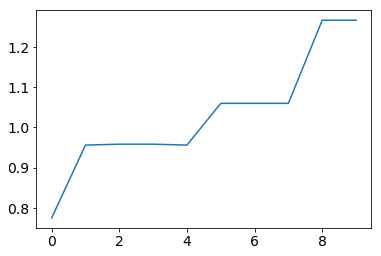

In [54]:
plt.plot(p)

In [196]:
len(r[0])

24

## Test results

In [204]:
def get_reference_data():
    def _ref_energy(Afolder):
        A = MrccCalculator.get_total_energy(Afolder)
        AB = MrccCalculator.get_total_energy(Afolder + 'B')
        B = MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')
        return AB-A-B
    def _pred_energy(Afolder):
        dZ = read_dZ_from_input('%s/run.inp' % Afolder)
        return predict(dZ)[0]
    
    res = []
    for case in range(1, 13):
        for mode in 'MIN MAX'.split():
            for rank in range(10):
                try:
                    Afolder = 'data/ga-search-2/validation/%d-%s-%d-A' % (case, mode, rank)
                    interaction_ref = _ref_energy(Afolder)
                    interaction_pred = _pred_energy(Afolder)
                except FileNotFoundError:
                    continue
                res.append({'pairs': case, 'mode': mode, 'interaction_ref': interaction_ref, 'interaction_pred': interaction_pred, 'rank': rank})
        for mode in 'MIN MAX'.split():
            for rank in range(10):
                try:
                    Afolder = 'data/ga-search-2/random/%d-%s-%d-A' % (case, mode, rank)
                    interaction_ref = _ref_energy(Afolder)
                    interaction_pred = _pred_energy(Afolder)
                except FileNotFoundError:
                    continue
                res.append({'pairs': case, 'mode': 'RAND', 'interaction_ref': interaction_ref, 'interaction_pred': interaction_pred, 'rank': rank})
    res = pd.DataFrame(res)
    res = res[abs(res.interaction_ref.values) < 5]
    return res
def read_dZ_from_input(infile):
    dZ = []
    started = False
    with open(infile) as fh:
        for line in fh.readlines(): 
            if started:
                dZ.append(int(line.split()[0])-6)
            if len(line.strip()) == 0:
                started = True
    return dZ[:24]
res = get_reference_data()

Text(0.5, 0, 'Number of BN pairs')

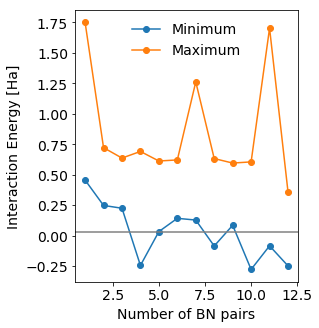

In [61]:
plt.rc('font', size=14)
f = plt.figure(figsize=(4, 5))
unsubstituted = MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-fast/QM/order-0/site-all-cc') - 2* MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')

s = res.query('mode == "MIN"').groupby('pairs').min().reset_index()
plt.plot(s.pairs, s.interaction_ref, 'o-',  label='Minimum')
s = res.query('mode == "MAX"').groupby('pairs').max().reset_index()
plt.plot(s.pairs, s.interaction_ref, 'o-', label='Maximum')
#s_up = res.query('mode == "RAND"').groupby('pairs').max().reset_index()
#s_dn = res.query('mode == "RAND"').groupby('pairs').min().reset_index()
#plt.fill_between(s_up.pairs, s_up.interaction_ref,s_dn.interaction_ref, label='Random')

plt.legend(frameon=False)
plt.axhline(unsubstituted, color='grey')
plt.ylabel('Interaction Energy [Ha]')
plt.xlabel('Number of BN pairs')
#plt.savefig('coronene-dimer-energies.pdf', bbox_inches='tight')

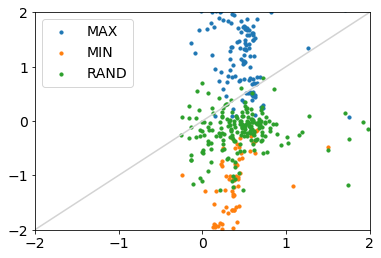

In [205]:
#res.query('mode == "MIN"').groupby('pairs').min()
for name, group in res.groupby('mode'):
    plt.scatter(group.interaction_ref, group.interaction_pred, label=name, s=10)
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot((-2, 2), (-2, 2), color='lightgrey')

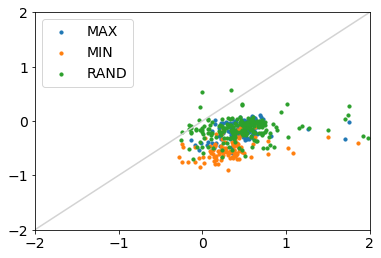

In [202]:
#res.query('mode == "MIN"').groupby('pairs').min()
for name, group in res.groupby('mode'):
    plt.scatter(group.interaction_ref, group.interaction_pred, label=name, s=10)
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot((-2, 2), (-2, 2), color='lightgrey')

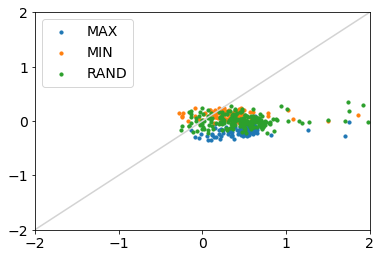

In [199]:
#res.query('mode == "MIN"').groupby('pairs').min()
for name, group in res.groupby('mode'):
    plt.scatter(group.interaction_ref, group.interaction_pred, label=name, s=10)
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot((-2, 2), (-2, 2), color='lightgrey')

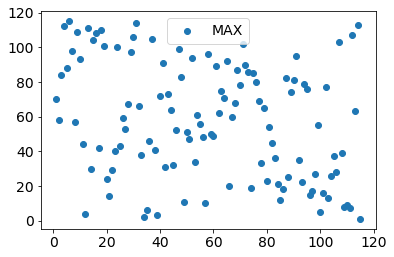

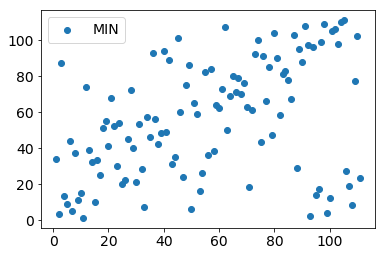

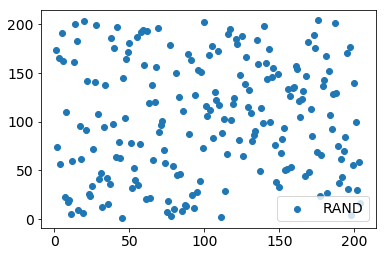

In [187]:
from scipy.stats import spearmanr
for name, group in res.groupby('mode'.split()):
    #print (name, spearmanr(group.interaction_pred.values, group.interaction_ref.values).correlation)
    p = group.interaction_pred.rank(method='first')
    r = group.interaction_ref.rank(method='first')
    plt.scatter(r, p, label=name)
    plt.legend()
    plt.show()